# Kubeflow Stats

* Notebook containing some plots of Kubeflow usage based on spartakus metrics

In [4]:
# Install and pin to versions that seem to work together
!pip3 install pandas-gbq==0.10.0  google-cloud-bigquery==1.11.2 google-api-core==1.8.2


    100% |████████████████████████████████| 133kB 3.8MB/s ta 0:00:01
    100% |████████████████████████████████| 71kB 22.7MB/s ta 0:00:01
  Found existing installation: google-api-core 1.9.0
    Uninstalling google-api-core-1.9.0:
      Successfully uninstalled google-api-core-1.9.0
  Found existing installation: google-cloud-core 1.0.1
    Uninstalling google-cloud-core-1.0.1:
      Successfully uninstalled google-cloud-core-1.0.1
  Found existing installation: google-cloud-bigquery 1.13.0
    Uninstalling google-cloud-bigquery-1.13.0:
      Successfully uninstalled google-cloud-bigquery-1.13.0
You are using pip version 19.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [ ]:
# Inline all matplotlib plots
%matplotlib inline

In [5]:
from google.cloud import bigquery

In [30]:
# NOTE: The RuntimeWarnings (if any) are harmless. See ContinuumIO/anaconda-issues#6678.
import pandas as pd
from pandas.io import gbq


In [7]:
# Note: access to this project is restricted
PROJECT="kubeflow-usage"

In [41]:
# We need to filter out empty timestamps because they can't be converted to dates
# Why would pings be missing a timestamp

# Get data for last year
max_age_hours = 24 * 365
query = """
    select TIMESTAMP_SECONDS(cast(timestamp as int64)) as timestamp, clusteriD FROM usage.collector 
    where timestamp is not null and length(timestamp) > 0 and
    timestamp_diff(CURRENT_TIMESTAMP(), TIMESTAMP_SECONDS(cast(timestamp as int64)), HOUR) < {max_age_hours}
""".format(max_age_hours=max_age_hours)

data=gbq.read_gbq(str(query), dialect='standard', project_id=PROJECT)


## Compute cluster stats


In [189]:
# Good reference for working with aggregations
# https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/
aggregations = {
    "timestamp": {
        "min_timestamp": "min",
        "max_timestamp": "max",
        "count": "count"
    }    
}
stats = data.groupby("clusteriD").agg(aggregations)

In [192]:
# Drop the multi-level index to make it easier to work with
stats.columns = stats.columns.droplevel(level=0)

In [194]:
stats["age"] = stats["max_timestamp"] - stats["min_timestamp"]

In [226]:
long_stats = stats[stats["age"] > datetime.timedelta(hours=24)]

## Number of new deployments

* Compute the number of new deployments in the last 28 days
* The number of new deployments will be noisy due to lots of very short lived deployments
* So we also show the number of new deployments that ended up living a minimum of 12 hours

In [217]:
new_per_day = pd.Series(data=1, index=stats["min_timestamp"])
new_per_day = new_per_day.sort_index()
new_deployments = new_per_day.rolling('28d').sum()

In [203]:
# TODO(jlewi): Seems a bit slow; could we speed it up somehow? Maybe less data
num_deployments = uid.rolling('28d').apply(lambda arr: pd.Series(arr).nunique())

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  


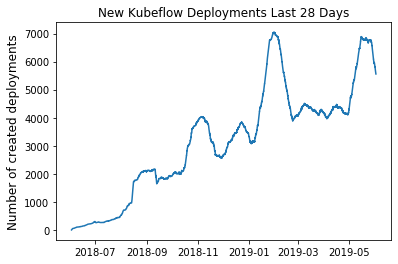

In [221]:
from matplotlib import pyplot as plt
plt.plot(new_deployments.index, new_deployments.values)
plt.title("New Kubeflow Deployments Last 28 Days")
plt.ylabel('Number of created deployments', fontsize='large');

In [227]:
new_per_day_long = pd.Series(data=1, index=long_stats["min_timestamp"])
new_per_day_long = new_per_day_long.sort_index()
new_deployments_long = new_per_day_long.rolling('28d').sum()

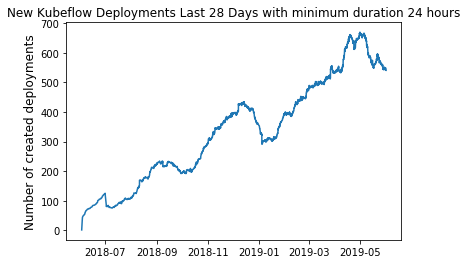

In [228]:
from matplotlib import pyplot as plt
plt.plot(new_deployments_long.index, new_deployments_long.values)
plt.title("New Kubeflow Deployments Last 28 Days with minimum duration 24 hours")
plt.ylabel('Number of created deployments', fontsize='large');

## Number of active deployments

* Compute the number of active deployments at any given time
* We do this by creating a time series of +1 at the first ping and -1 at the last ping
* We then integrate over this time series
* This means we filter out any deployments for which we only have a single ping which means we should exclude clusters with a lifetime of less than 1 day

In [296]:
# We need to drop unknown_cluster and empty string because those represent
# multiple clusters and the min and max timestamp will not correspond to the duration
# of those clusters

filtered_stats = stats[np.logical_and(stats.index != "" , stats.index != "unknown_cluster")]

create_times = pd.Series(data=1, index=filtered_stats["min_timestamp"])
delete_times = pd.Series(data=-1, index=filtered_stats["max_timestamp"])

# Drop delete_times and create_times which are less than 24 hours old.
# We assume those clusters are still active. So we don't want to interpret the
# max ping timestamp as a delete timestamp
now = datetime.datetime.now(delete_times.index.tzinfo)

min_hours = 48
create_times = create_times[now - create_times.index > datetime.timedelta(hours=min_hours)]
delete_times = delete_times[now - delete_times.index > datetime.timedelta(hours=min_hours)]

In [297]:
deltas = pd.concat([create_times, delete_times])
deltas = deltas.sort_index()
active_deployments= deltas.cumsum()

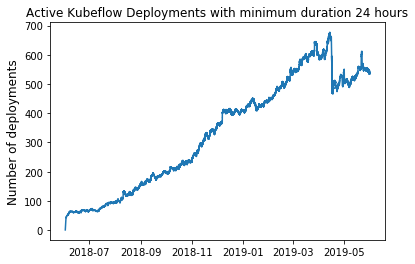

In [298]:
plt.plot(active_deployments.index, active_deployments.values)
plt.title("Active Kubeflow Deployments with minimum duration 24 hours")
plt.ylabel('Number of deployments', fontsize='large');

## Compute histogram of Kubeflow deployment age for

In [323]:
last_28 = stats[now - stats["min_timestamp"] < datetime.timedelta(days=28)]
age_counts = pd.Series(data=1, index=last_28["age"])
age_counts=age_counts.sort_index()
age_stats = age_counts.cumsum()

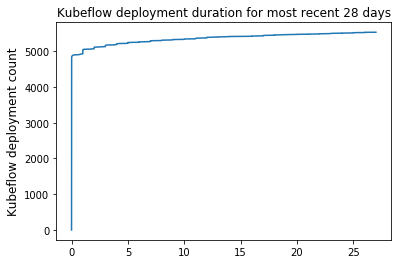

In [324]:
plt.plot(age_stats.index.total_seconds() / (24.0 * 3600), age_stats.values)
plt.title("Kubeflow deployment duration for most recent 28 days")
plt.ylabel('Kubeflow deployment count', fontsize='large');

In [328]:
# Compute a plot of age stats for clusters that have a minimum age of 1 day
# Excluding short lived clusters filters out short lived automated clusters from testing 
# and other data
last_28_long = last_28[last_28["age"] > datetime.timedelta(hours=24)]
age_counts_long = pd.Series(data=1, index=last_28_long["age"])
age_counts_long=age_counts_long.sort_index()
age_stats_long = age_counts_long.cumsum()
age_cpdf_long = age_stats_long / age_stats_long.max()

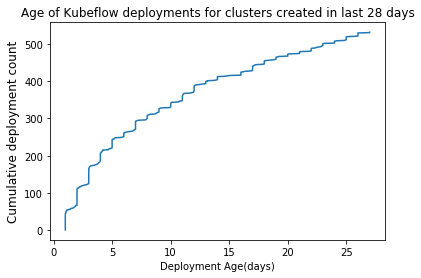

In [333]:
plt.plot(age_stats_long.index.total_seconds() / (24.0 * 3600), age_stats_long.values)
plt.title("Age of Kubeflow deployments for clusters created in last 28 days")
plt.xlabel("Deployment Age(days)")
plt.ylabel('Cumulative deployment count', fontsize='large');

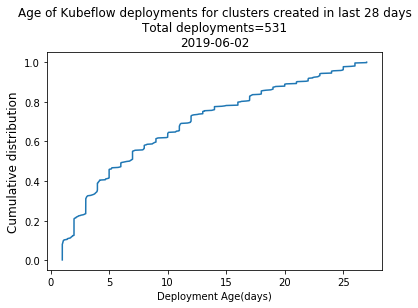

In [339]:
plt.plot(age_cpdf_long.index.total_seconds() / (24.0 * 3600), age_cpdf_long.values)
now_day = now.strftime("%Y-%m-%d")
plt.title("Age of Kubeflow deployments for clusters created in last 28 days\nTotal deployments={0}\n{1}".format(age_stats_long.max(), now_day))
plt.xlabel("Deployment Age(days)")
plt.ylabel('Cumulative distribution', fontsize='large');

In [345]:
last_28_long["age"].quantile([.25, .5, .75, .9])

0.25           3 days 00:00:00
0.50           6 days 18:15:36
0.75   13 days 00:00:13.500000
0.90          21 days 00:00:10
Name: age, dtype: timedelta64[ns]